In [1]:
using Gen, Plots

In [2]:
using DataFrames, CSV

In [3]:
Ts = 0:0.05:4
Ts = convert(Vector{Float64},Ts);

In [4]:
    x_std_alpha = 3
    v_x_std_alpha = 3
    x_std_beta = 0.5
    v_x_std_beta = 0.01

0.01

In [189]:

@gen function friction_model(Ts::Vector{Float64})
    
    del_t = 0.05
    g = 9.8
    x_mu = 0 # 1
    v_x_mu = 5 
    x_std = 0.05
    v_x_std = 0.05
    
    z_mu = 2.5 # 5 
    v_z_mu = 0.05 
    z_std = 1
    v_z_std = 0.05
    
    velocity_thresh = 1e-4
    falling_std = 1e-3
    # HB hyperprior: 
    # mean of inv_gamma ~ beta/alpha
    # var ~ beta^2/alpha^3 for large alpha    
    # obs_std_shape = 20 # alpha
    # obs_std_scale = 0.025 # beta
    # obs_std = inv_gamma(obs_std_shape, obs_std_scale)
    
    obs_std = 1e-3
        
    friction = {:friction} ~ uniform(0.1, 1)

    xs = Vector{Float64}(undef, size(Ts)[1])
    vxs = Vector{Float64}(undef, size(Ts)[1])
    noisy_xs = Vector{Float64}(undef, size(Ts)[1])
    zs = Vector{Float64}(undef, size(Ts)[1])
    vzs = Vector{Float64}(undef, size(Ts)[1])
    noisy_zs = Vector{Float64}(undef, size(Ts)[1])

    xs[1] = {(:init_x, 0)} ~ normal(x_mu, x_std)
    zs[1] = {(:init_z, 0)} ~ normal(z_mu, z_std)
    noisy_xs[1] = {(:x, 0)} ~ normal(xs[1], falling_std)
    noisy_zs[1] = {(:z, 0)} ~ normal(zs[1], falling_std)
    vxs[1] = {(:vx, 0)} ~ normal(v_x_mu, v_x_std)
    vzs[1] = {(:vz, 0)} ~ normal(v_z_mu, v_z_std)
    
    
   # generate successive states and measurements
    for (i, t) in enumerate(Ts[2:end])
        i = i+1
        if zs[i-1] <= 0.1917 #0
            if vxs[i-1] >= 2 * velocity_thresh
                xs[i] = xs[i-1] + vxs[i-1] * del_t - 0.5 * friction * g * del_t^2
                zs[i] = 0
                vxs[i] = vxs[i-1] - friction * g * del_t
                vzs[i] = 0
                noisy_zs[i] = {(:z, i)} ~ normal(zs[i], sqrt(obs_std))
                noisy_xs[i] = {(:x, i)} ~ normal(xs[i], sqrt(obs_std))
            else
                xs[i] = xs[i-1]
                zs[i] = 0
                noisy_zs[i] = {(:z, i)} ~ normal(zs[i], sqrt(obs_std))
                noisy_xs[i] = {(:x, i)} ~ normal(xs[i], sqrt(obs_std))
            end
        else
                zs[i] = max(zs[i-1] + vzs[i-1] * del_t - 0.5 * g * del_t^2,0)
                vzs[i] = vzs[i-1] - g * del_t
                xs[i] = xs[i-1] + vxs[i-1] * del_t
                vxs[i] = vxs[i-1]
                noisy_zs[i] = {(:z, i)} ~ normal(zs[i], sqrt(obs_std))
                noisy_xs[i] = {(:x, i)} ~ normal(xs[i], sqrt(obs_std))
        end
    end
        
    return noisy_xs, noisy_zs
    #return xs, zs
end;


In [190]:
trace = Gen.simulate(friction_model, (Ts,));




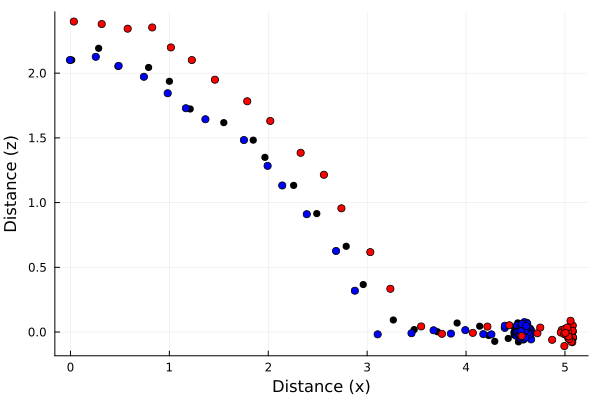

In [198]:
## two sample rollouts

p = plot()
trace = Gen.simulate(friction_model, (Ts,));
trace1 = Gen.simulate(friction_model, (Ts,));
trace2 = Gen.simulate(friction_model, (Ts,));
scatter!(get_retval(trace)[1], get_retval(trace)[2], c="black", label=nothing)
scatter!(get_retval(trace1)[1], get_retval(trace1)[2], c="blue", label=nothing)
scatter!(get_retval(trace2)[1], get_retval(trace2)[2], c="red", label=nothing)
xlabel!("Distance (x)")
ylabel!("Distance (z)")

In [15]:
function do_inference_falling(model, ts, xs, amount_of_computation)
    
    observations = Gen.choicemap()
    for (i, x) in enumerate(xs)
        observations[(:x, i)] = x
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (ts,), observations, amount_of_computation);
    return trace
end;


In [33]:
ts, = get_args(trace)
xs, = get_retval(trace);



In [71]:
function do_inference(model, ts, xs, amount_of_computation)
    
    observations = Gen.choicemap()
    for (i, x) in enumerate(xs)
        observations[(:x, i)] = x
        observations[(:z, i)] = 0
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (ts,), observations, amount_of_computation);
    return trace
end;



In [72]:
trace = do_inference(friction_model, ts, xs, 1000)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##friction_model#293", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:z, 4) => Gen.ChoiceOrCallRecord{Float64}(0.0, -105.22603233506469, NaN, true), (:x, 4) => Gen.ChoiceOrCallRecord{Float64}(1.603316068649292, -207.85103975604136, NaN, true), (:z, 26) => Gen.ChoiceOrCallRecord{Float64}(0.0, 2.1652100203434586, NaN, true), (:x, 36) => Gen.ChoiceOrCallRecord{Float64}(6.940012454986572, -55.877961225351896, NaN, true), (:x, 41) => Gen.ChoiceOrCallRecord{Float64}(6.940011978149414, -5.937849940129222, NaN, true), (:x, 45) => Gen.ChoiceOrCallRecord{Float64}(6.940011978149414, 1.4042969110470178, NaN, true), (:x, 24) => Gen.ChoiceOrCallRecord{Float64}(6.815036773681641, -758.82986708642, NaN, true), (:z, 7) => Gen.ChoiceOrCallRecord{Float64}(0.0, -26.321804727030678, NaN, t

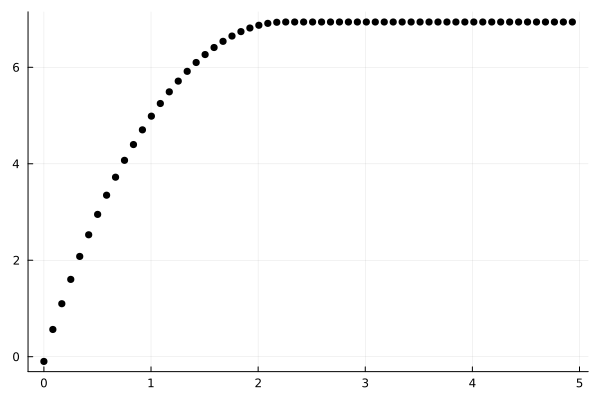

In [73]:
fig = plot()
scatter!(get_args(trace), get_retval(trace)[1], c="black", label=nothing)

In [76]:
xs_bullet = CSV.read("xs.csv", DataFrame)
xs_bullet = Matrix(xs_bullet)[:,1]
ts_bullet = collect(LinRange(0,5,300))

xs_bullet = xs_bullet[1:5:end]
ts_bullet = ts_bullet[1:5:end];




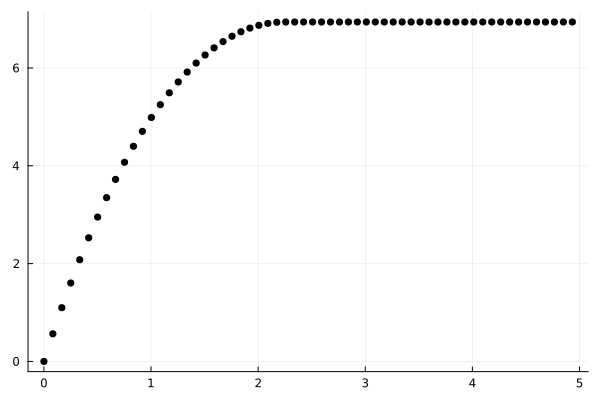

In [77]:
#sliding block plot
fig = plot()
scatter!(ts_bullet, xs_bullet, c="black", label=nothing)



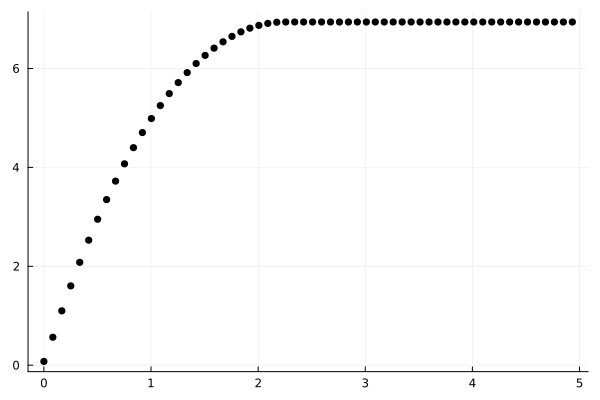

In [78]:

trace = do_inference(friction_model, ts_bullet, xs_bullet, 10000)
fig = plot()
scatter!(get_args(trace), get_retval(trace), c="black", label=nothing)



In [81]:
p = plot()
scatter!(ts_bullet, xs_bullet, c="black", label="Observed")
scatter!(get_args(trace), get_retval(trace), c="blue", label="Trace return")
xlabel!("Time (s)")
ylabel!("Distance (x)")
savefig(p,"infer_slide_traj.png")

"/Users/esli/gen-tracker/infer_slide_traj.png"